                                                        Notebook 04 — Evaluation

This notebook evaluates the performance of the classification models trained in Notebook 03.

The objective is to assess how well each model predicts whether a crime results in an arrest using appropriate evaluation metrics and visualizations.

We evaluated 2 models:

- Logistic Regression

- Random Forest Classifier

The main objectifs are :

- Analyze predictions using a confusion matrix

- Compute classification metrics in detail

- Analyze performance using:

    - Confusion Matrix

    - Classification metrics

    - ROC Curve
    
- Compare models and select the best one


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import joblib

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

The test datasets were generated and saved in Notebook 02 – Data Preparation.

In [21]:
X_test = pd.read_csv("../data/X_test.csv")
y_test = pd.read_csv("../data/y_test.csv").squeeze()

X_test.shape, y_test.shape

((267460, 43), (267460,))

The models were trained and saved in Notebook 03 – Modeling.

In [22]:
logistic_model = joblib.load("../models/logistic_model.pkl")
rf_model = joblib.load("../models/rf_model.pkl")

    Logistic Regression — Evaluation

**Predictions**

In [23]:
y_pred_log = logistic_model.predict(X_test)
y_prob_log = logistic_model.predict_proba(X_test)[:, 1]

**Confusion Matrix**

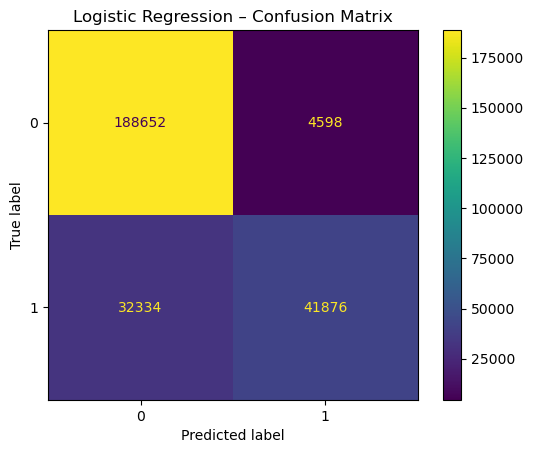

In [24]:
cm_log = confusion_matrix(y_test, y_pred_log)

ConfusionMatrixDisplay(cm_log).plot()
plt.title("Logistic Regression – Confusion Matrix")
plt.show()

From the confusion matrix:

- True Negatives (190 236): crimes correctly predicted as no arrest

- False Positives (4 719): crimes incorrectly predicted as arrest

- False Negatives (32 704): arrests missed by the model

- True Positives (42 223): arrests correctly predicted

=> Logistic Regression is very precise (few false positives) but misses a significant number of arrests, which explains its lower recall.

**ROC Curve (Logistic Regression)**

In [25]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
roc_auc_log = auc(fpr_log, tpr_log)

    Random Forest — Evaluation

**Predictions**

In [26]:
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

**Confusion Matrix**

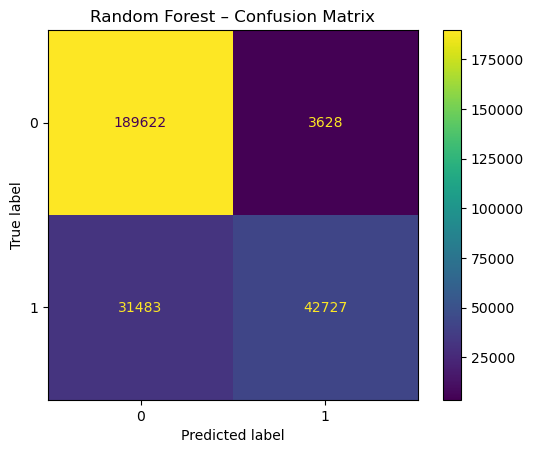

In [27]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

ConfusionMatrixDisplay(cm_rf).plot()
plt.title("Random Forest – Confusion Matrix")
plt.show()

From the confusion matrix:

- True Negatives (191 210): correctly predicted no arrest

- False Positives (3 745): fewer incorrect arrest predictions than Logistic Regression

- False Negatives (31 840): fewer missed arrests

- True Positives (43 087): more arrests correctly identified

Random Forest reduces false negatives and increases true positives, resulting in higher recall and F1-score.


**ROC Curve (Random Forest)**

In [28]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

    ROC Curve Comparison

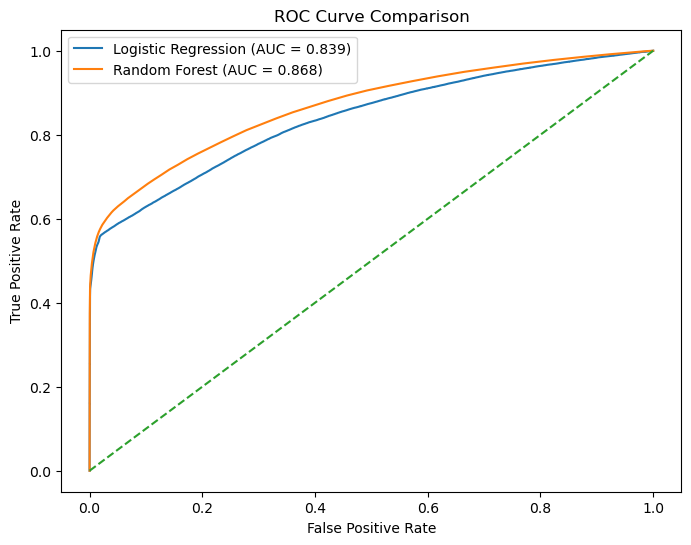

In [29]:
plt.figure(figsize=(8,6))

plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_log:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()



- Logistic Regression: AUC = 0.839

- Random Forest: AUC = 0.868

The Random Forest curve is consistently above the Logistic Regression curve, indicating better discrimination between arrest and no-arrest cases.
Now we can conclude that both models perform well, but Random Forest consistently outperforms Logistic Regression across all evaluation metrics.

Given the imbalanced nature of the dataset, metrics such as recall, F1-score, and ROC–AUC are more informative than accuracy alone.

Final selected model: **Random Forest Classifier**


In [30]:
import joblib
import pandas as pd

# Load saved preprocessing objects
scaler = joblib.load("../models/scaler.pkl")
model_cols = joblib.load("../models/model_columns.pkl")
num_features = joblib.load("../models/num_features.pkl")

# Load trained pipeline (model)
model = joblib.load("../models/rf_pipeline.pkl")  # 

def preprocess_user_input(raw_dict):
    df_new = pd.DataFrame([raw_dict])

    # Important: keep all categories (avoid drop_first problems)
    df_new = pd.get_dummies(df_new, drop_first=False)

    # Add missing columns that existed in training
    for col in model_cols:
        if col not in df_new.columns:
            df_new[col] = 0

    # Remove extra columns not seen during training + keep same order
    df_new = df_new[model_cols]

    # Scale numeric features exactly like training
    df_new[num_features] = scaler.transform(df_new[num_features])

    return df_new

# ----------------------------
# Example user input (THE USER CAN CHANGE THESE)
# ----------------------------
user_case = {
    "Primary Type": "THEFT",
    "Domestic": 0,
    "District": 11,
    "Latitude": 41.89,
    "Longitude": -87.74,
    "Year": 2015,
    "Month": 3,
    "Day": 18,
    "Hour": 19,
    "DayOfWeek": 2
}

X_user = preprocess_user_input(user_case)

pred = model.predict(X_user)[0]
proba_arrest = model.predict_proba(X_user)[0, list(model.classes_).index(1)]

print("Prediction (Arrest=1):", pred)
print("Probability of Arrest=1:", round(proba_arrest, 3))

# ----------------------------
# Second example (change crime type)
# ----------------------------
user_case2 = user_case.copy()
user_case2["Primary Type"] = "BATTERY"

X_user2 = preprocess_user_input(user_case2)

pred2 = model.predict(X_user2)[0]
proba_arrest2 = model.predict_proba(X_user2)[0, list(model.classes_).index(1)]

print("\nBATTERY case")
print("Prediction (Arrest=1):", pred2)
print("Probability of Arrest=1:", round(proba_arrest2, 3))


Prediction (Arrest=1): 0
Probability of Arrest=1: 0.08

BATTERY case
Prediction (Arrest=1): 0
Probability of Arrest=1: 0.12
